In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import os

# Set plot style
plt.style.use('default')  # Changed from 'seaborn' to 'default'
sns.set_theme()  # This will set a nice seaborn theme

# Path to the CSV files directory (using current directory)
csv_dir = "."  # Changed to current directory

In [2]:
def load_csv(filename):
    """Loads a CSV file and returns it as a DataFrame."""
    file_path = os.path.join(csv_dir, filename)
    print(f"Loading {filename}...")
    try:
        return pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: Could not find {file_path}")
        print(f"Current working directory: {os.getcwd()}")
        print(f"Files in current directory: {os.listdir('.')}")
        raise

# Load necessary datasets
players_df = load_csv("players.csv")
clubs_df = load_csv("clubs.csv")
player_valuations_df = load_csv("player_valuations.csv")
appearances_df = load_csv("appearances.csv")

# Display basic information about the datasets
print("\nDataset shapes:")
print(f"Players: {players_df.shape}")
print(f"Clubs: {clubs_df.shape}")
print(f"Player Valuations: {player_valuations_df.shape}")
print(f"Appearances: {appearances_df.shape}")

Loading players.csv...
Error: Could not find .\players.csv
Current working directory: d:\transfermarkt\footbal_transfermarkt
Files in current directory: ['.git', '.gitignore', 'data', 'ed_players.ipynb', 'player_value_analysis.ipynb', 'README.md', 'requirements.txt']


FileNotFoundError: [Errno 2] No such file or directory: '.\\players.csv'

In [3]:
def prepare_player_performance_metrics(appearances_df, player_valuations_df):
    """Prepares player performance metrics from appearances data."""
    # Calculate per-game metrics
    player_performance = appearances_df.groupby('player_id').agg({
        'goals': ['sum', 'mean'],
        'assists': ['sum', 'mean'],
        'minutes_played': ['sum', 'mean'],
        'yellow_cards': ['sum', 'mean'],
        'red_cards': ['sum', 'mean'],
        'game_id': 'count'  # number of games
    }).reset_index()
    
    # Flatten column names
    player_performance.columns = ['player_id', 
                                'total_goals', 'goals_per_game',
                                'total_assists', 'assists_per_game',
                                'total_minutes', 'minutes_per_game',
                                'total_yellow_cards', 'yellow_cards_per_game',
                                'total_red_cards', 'red_cards_per_game',
                                'games_played']
    
    # Calculate additional metrics
    player_performance['goal_contributions'] = player_performance['total_goals'] + player_performance['total_assists']
    player_performance['goal_contributions_per_game'] = player_performance['goal_contributions'] / player_performance['games_played']
    player_performance['minutes_per_goal_contribution'] = player_performance['total_minutes'] / player_performance['goal_contributions'].replace(0, 1)
    
    return player_performance

# Prepare player performance metrics
player_performance = prepare_player_performance_metrics(appearances_df, player_valuations_df)
print("\nPlayer Performance Metrics Sample:")
print(player_performance.head())


Player Performance Metrics Sample:
   player_id  total_goals  goals_per_game  total_assists  assists_per_game  \
0         10           48        0.352941             25          0.183824   
1         26            0        0.000000              0          0.000000   
2         65           38        0.311475             13          0.106557   
3         77            0        0.000000              0          0.000000   
4         80            0        0.000000              0          0.000000   

   total_minutes  minutes_per_game  total_yellow_cards  yellow_cards_per_game  \
0           8808         64.764706                  19               0.139706   
1          13508         88.868421                   4               0.026316   
2           8788         72.032787                  11               0.090164   
3            307         76.750000                   0               0.000000   
4           1080         90.000000                   0               0.000000   

   total

In [4]:
# Calculate club performance metrics
club_performance = appearances_df.groupby('player_club_id').agg({
    'goals': 'sum',
    'assists': 'sum',
    'minutes_played': 'sum',
    'yellow_cards': 'sum',
    'red_cards': 'sum'
}).reset_index()

# Rename the column to match clubs.csv
club_performance = club_performance.rename(columns={'player_club_id': 'club_id'})

# Merge club performance with club information
club_metrics = pd.merge(
    clubs_df,
    club_performance,
    how='left',
    on='club_id'
)

# Calculate average player value per club
club_player_values = player_valuations_df.groupby('current_club_id')['market_value_in_eur'].agg([
    'mean',
    'median',
    'max',
    'min',
    'count'
]).reset_index()

club_player_values.columns = [
    'club_id',
    'avg_player_value',
    'median_player_value',
    'max_player_value',
    'min_player_value',
    'player_count'
]

# Merge club metrics with player values
club_metrics = pd.merge(
    club_metrics,
    club_player_values,
    how='left',
    on='club_id'
)

# Calculate club influence metrics
club_metrics['club_prestige_score'] = (
    club_metrics['total_market_value'].fillna(0) * 
    club_metrics['squad_size'].fillna(0) * 
    (1 + club_metrics['national_team_players'].fillna(0) / club_metrics['squad_size'].fillna(1))
)

club_metrics['international_exposure'] = (
    club_metrics['foreigners_percentage'].fillna(0) * 
    club_metrics['squad_size'].fillna(0)
)

club_metrics['infrastructure_score'] = (
    club_metrics['stadium_seats'].fillna(0) * 
    (1 + club_metrics['squad_size'].fillna(0) / 25)
)

club_metrics['financial_health'] = (
    club_metrics['net_transfer_record'].str.extract(r'([-+]?\d+\.?\d*)').astype(float) * 1000000
)

# Normalize metrics
scaler = StandardScaler()
metrics_to_normalize = [
    'club_prestige_score',
    'international_exposure',
    'infrastructure_score',
    'financial_health',
    'avg_player_value'
]

for metric in metrics_to_normalize:
    if metric in club_metrics.columns:
        club_metrics[f'{metric}_normalized'] = scaler.fit_transform(
            club_metrics[[metric]].fillna(0)
        )

# Calculate overall club influence score
club_metrics['club_influence_score'] = (
    club_metrics['club_prestige_score_normalized'] * 0.3 +
    club_metrics['international_exposure_normalized'] * 0.2 +
    club_metrics['infrastructure_score_normalized'] * 0.2 +
    club_metrics['financial_health_normalized'] * 0.3
)

print("\nTop 10 clubs by influence score:")
print(club_metrics.nlargest(10, 'club_influence_score')[['name', 'club_influence_score', 'club_prestige_score']])


Top 10 clubs by influence score:
                                      name  club_influence_score  \
426                           Leeds United              1.667373   
77   Real Valladolid Club de Fútbol S.A.D.              1.608031   
175                              Málaga CF              1.311716   
202                    Queens Park Rangers              1.309037   
28                          MKE Ankaragücü              1.304781   
1                       Ural Yekaterinburg              1.235049   
394                     Fortuna Düsseldorf              1.232840   
95                         Odense Boldklub              1.211382   
360                 Eintracht Braunschweig              1.052821   
392                    Panserraikos Serres              0.922527   

     club_prestige_score  
426                  0.0  
77                   0.0  
175                  0.0  
202                  0.0  
28                   0.0  
1                    0.0  
394                  0.0  
9

In [9]:
def predict_player_values(player_club_analysis, club_metrics, appearances_df, players_df):
    """Uses Random Forest to predict player market values based on player performance and club context."""
    # Prepare player performance metrics
    player_performance = prepare_player_performance_metrics(appearances_df, player_club_analysis)
    
    # Merge performance metrics with player analysis
    player_club_analysis = pd.merge(
        player_club_analysis,
        player_performance,
        on='player_id',
        how='left'
    )
    
    # Merge player information
    player_club_analysis = pd.merge(
        player_club_analysis,
        players_df[['player_id', 'name', 'position']],
        on='player_id',
        how='left'
    )
    
    # Merge club characteristics and names
    player_club_analysis = pd.merge(
        player_club_analysis,
        club_metrics[['club_id', 'name', 'squad_size', 'average_age', 'foreigners_percentage', 
                     'national_team_players', 'stadium_seats']],
        on='club_id',
        how='left',
        suffixes=('_player', '_club')
    )
    
    # Prepare features for prediction
    features = [
        # Club context features
        'club_influence_score',
        'club_prestige_score',
        'avg_player_value',
        'value_to_club_avg_ratio',
        
        # Player performance features
        'total_goals',
        'total_assists',
        'goal_contributions',
        'goal_contributions_per_game',
        'minutes_per_goal_contribution',
        'games_played',
        'total_minutes',
        'total_yellow_cards',
        'total_red_cards',
        
        # Club characteristics
        'squad_size',
        'average_age',
        'foreigners_percentage',
        'national_team_players',
        'stadium_seats'
    ]
    
    # Fill missing values with 0 for numeric columns
    player_club_analysis[features] = player_club_analysis[features].fillna(0)
    
    # Prepare target variable (log-transformed market value for better prediction)
    target = np.log1p(player_club_analysis['market_value_in_eur'])
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        player_club_analysis[features],
        target,
        test_size=0.2,
        random_state=42
    )
    
    # Train Random Forest model with reduced parameters
    rf_model = RandomForestRegressor(
        n_estimators=50,  # Reduced from 200 to 50
        max_depth=10,     # Reduced from 15 to 10
        min_samples_split=5,
        min_samples_leaf=2,
        n_jobs=-1,        # Use all available CPU cores
        random_state=42
    )
    
    print("Training Random Forest model...")
    rf_model.fit(X_train, y_train)
    print("Model training completed!")
    
    # Make predictions
    train_predictions = rf_model.predict(X_train)
    test_predictions = rf_model.predict(X_test)
    
    # Calculate model performance
    train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
    test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
    train_r2 = r2_score(y_train, train_predictions)
    test_r2 = r2_score(y_test, test_predictions)
    
    print(f"\nModel Performance:")
    print(f"Training RMSE: {train_rmse:.3f}")
    print(f"Testing RMSE: {test_rmse:.3f}")
    print(f"Training R²: {train_r2:.3f}")
    print(f"Testing R²: {test_r2:.3f}")
    
    # Get feature importance
    feature_importance = pd.DataFrame({
        'feature': features,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nTop 10 Most Important Features:")
    print(feature_importance.head(10))
    
    # Add predictions to the analysis DataFrame
    player_club_analysis['predicted_value'] = np.expm1(rf_model.predict(player_club_analysis[features]))
    player_club_analysis['value_difference'] = (
        player_club_analysis['market_value_in_eur'] - player_club_analysis['predicted_value']
    )
    player_club_analysis['value_difference_percentage'] = (
        (player_club_analysis['value_difference'] / player_club_analysis['predicted_value']) * 100
    )
    
    return player_club_analysis

# Merge player valuations with club metrics
player_club_analysis = pd.merge(
    player_valuations_df,
    club_metrics[['club_id', 'club_influence_score', 'avg_player_value', 'club_prestige_score']],
    how='left',
    left_on='current_club_id',
    right_on='club_id'
)

# Calculate player value ratios
player_club_analysis['value_to_club_avg_ratio'] = (
    player_club_analysis['market_value_in_eur'] / 
    player_club_analysis['avg_player_value']
)

# Run the prediction model
print("Starting prediction process...")
player_club_analysis = predict_player_values(player_club_analysis, club_metrics, appearances_df, players_df)
print("Prediction process completed!")

Starting prediction process...
Training Random Forest model...
Model training completed!

Model Performance:
Training RMSE: 0.033
Testing RMSE: 0.044
Training R²: 1.000
Testing R²: 0.999

Top 10 Most Important Features:
                          feature    importance
3         value_to_club_avg_ratio  6.750373e-01
2                avg_player_value  3.249402e-01
0            club_influence_score  7.447603e-06
13                     squad_size  4.725845e-06
16          national_team_players  4.216869e-06
14                    average_age  2.534227e-06
17                  stadium_seats  1.918678e-06
15          foreigners_percentage  9.208508e-07
8   minutes_per_goal_contribution  2.509789e-07
7     goal_contributions_per_game  1.536380e-07
Prediction process completed!


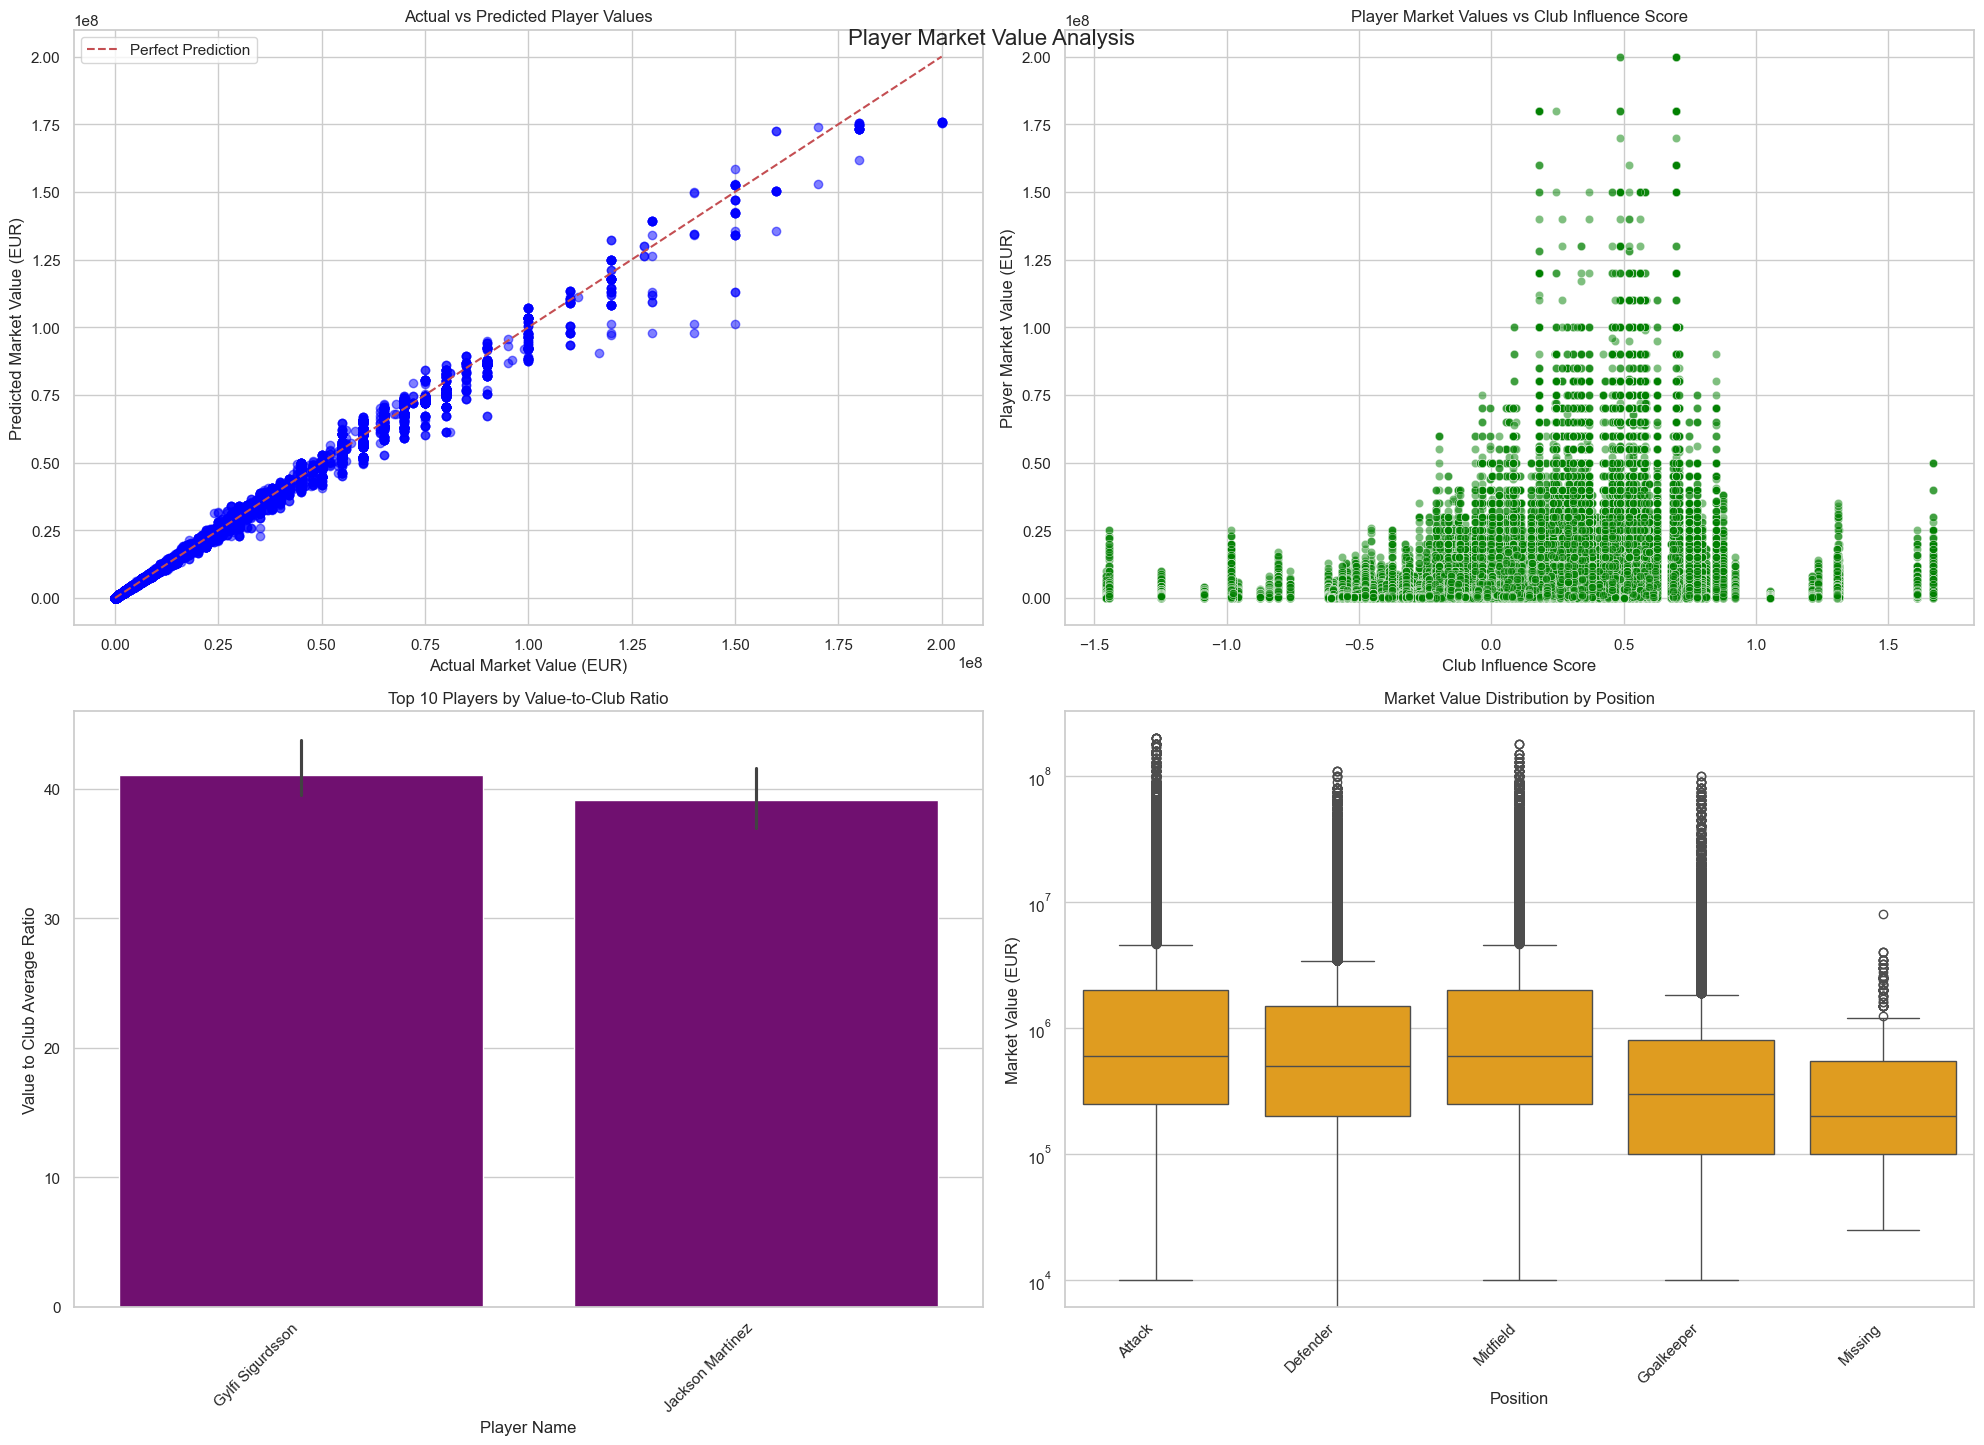


Top 5 Most Overvalued Players:
              name_player    position                   name_club  market_value_in_eur  predicted_value  value_difference_percentage  goal_contributions_per_game
365419   Patricio Goglino      Attack           Parma Calcio 1913                20000     1.258774e+04                    58.884781                     0.000000
275210   Gylfi Sigurdsson    Midfield  Lyngby Boldklubben af 1921             35000000     2.280375e+07                    53.483497                     0.368421
79914     Patrik Carlgren  Goalkeeper     Football Club de Nantes                40000     2.681148e+04                    49.189826                     0.000000
250225  Philippe Coutinho    Midfield   Aston Villa Football Club            150000000     1.012512e+08                    48.146376                     0.421320
138405    Eric Björkander    Defender                    Altay SK                40000     2.725636e+04                    46.754752                     0.041

In [14]:
# Set the style for all plots
plt.style.use('default')
sns.set_theme(style="whitegrid")

# Create a figure with subplots
fig = plt.figure(figsize=(20, 15))
fig.suptitle('Player Market Value Analysis', fontsize=16, y=0.95)

# 1. Actual vs Predicted Values
plt.subplot(2, 2, 1)
plt.scatter(
    player_club_analysis['market_value_in_eur'],
    player_club_analysis['predicted_value'],
    alpha=0.5,
    color='blue'
)
plt.plot([0, player_club_analysis['market_value_in_eur'].max()],
         [0, player_club_analysis['market_value_in_eur'].max()],
         'r--', label='Perfect Prediction')
plt.title('Actual vs Predicted Player Values')
plt.xlabel('Actual Market Value (EUR)')
plt.ylabel('Predicted Market Value (EUR)')
plt.legend()

# 2. Player Values by Club Influence
plt.subplot(2, 2, 2)
sns.scatterplot(
    data=player_club_analysis,
    x='club_influence_score',
    y='market_value_in_eur',
    alpha=0.5,
    color='green'
)
plt.title('Player Market Values vs Club Influence Score')
plt.xlabel('Club Influence Score')
plt.ylabel('Player Market Value (EUR)')

# 3. Top Players by Value-to-Club Ratio
plt.subplot(2, 2, 3)
top_players = player_club_analysis.nlargest(10, 'value_to_club_avg_ratio')
sns.barplot(
    data=top_players,
    x='name_player',
    y='value_to_club_avg_ratio',
    color='purple'
)
plt.title('Top 10 Players by Value-to-Club Ratio')
plt.xlabel('Player Name')
plt.ylabel('Value to Club Average Ratio')
plt.xticks(rotation=45, ha='right')

# 4. Market Value Distribution by Position
plt.subplot(2, 2, 4)
sns.boxplot(
    data=player_club_analysis,
    x='position',
    y='market_value_in_eur',
    color='orange'
)
plt.title('Market Value Distribution by Position')
plt.xlabel('Position')
plt.ylabel('Market Value (EUR)')
plt.xticks(rotation=45, ha='right')
plt.yscale('log')

# Adjust layout
plt.tight_layout()
plt.show()

# Print analysis results
print("\nTop 5 Most Overvalued Players:")
print(player_club_analysis.nlargest(5, 'value_difference_percentage')[
    ['name_player', 'position', 'name_club', 'market_value_in_eur', 'predicted_value', 
     'value_difference_percentage', 'goal_contributions_per_game']
].to_string())

print("\nTop 5 Most Undervalued Players:")
print(player_club_analysis.nsmallest(5, 'value_difference_percentage')[
    ['name_player', 'position', 'name_club', 'market_value_in_eur', 'predicted_value', 
     'value_difference_percentage', 'goal_contributions_per_game']
].to_string())

# Analyze value differences by position
print("\nAverage Value Difference by Position:")
position_analysis = player_club_analysis.groupby('position').agg({
    'value_difference_percentage': 'mean',
    'market_value_in_eur': 'mean',
    'predicted_value': 'mean'
}).round(2)
print(position_analysis.to_string())